In [1]:
%cd drive/MyDrive/RLWorms_Data/Agents

/content/drive/MyDrive/RLWorms_Data/Agents


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SAC as sac
import torch
import pickle
from torch import nn
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def check_ens_xy(actor, loc, speed=0, frames=15, disc=36, shift_relative=True):
    bodies = np.arange(-180,180,10)
    heads = np.arange(-180,180,10)

    choices = np.zeros((disc,disc))
    standard = np.zeros((disc,disc))

    # Shift body angles so it's relative to target
    if shift_relative:
        shift = np.arctan2(loc[1],-loc[0]) *180/np.pi
        if shift<0: shift+=360 # Runs from 0 to 360 now
        shift_ind = int(shift/360 * disc) # This gives how many indices to move to the right.

        bodies = np.roll(bodies, shift_ind)
        
    states = []
    for b_i, b in enumerate(bodies):
        for h_i, h in enumerate(heads):
            b_ang = b*np.pi/180
            h_ang = h*np.pi/180

            h_ang += b_ang
            if h_ang < -np.pi: 
                h_ang += 2*np.pi
            elif h_ang > np.pi:
                h_ang -= 2*np.pi

            state = torch.repeat_interleave(torch.tensor([np.sin(b_ang),np.cos(b_ang),np.sin(h_ang),np.cos(h_ang),*loc]),frames)
            states.append((state).view(1,-1).type(torch.float))
  
    states = torch.cat(states, dim=0)
    # x shift. Keeps the input location as the average.
    states[:,-2*frames:-frames] += (torch.broadcast_to(torch.arange(frames)*speed,(states.shape[0],frames)))-((frames-1)/2)*speed
    # Right now it's for individual agents; commented out part is for ensemble
    return actor(states)
    choices = actor(states)[1].view(disc,disc) #actor.prob(states).view(disc,disc)

    return choices

class Ensemble(nn.Module):
    def __init__(self, actors, actions=2):
        super(Ensemble, self).__init__()
        self.actors = nn.ModuleList(actors)
        self.actions = actions

    def forward(self, state):
        sums = torch.cat([act(state)[1].detach().view(state.shape[0],self.actions,1) for act in self.actors], dim=2)
        sums = torch.mean(sums, dim=2)
        return torch.argmax(sums, dim=1)
    
    def prob(self, state):
        # Returns probability of light on.
        sums = torch.cat([act(state)[1].detach().view(state.shape[0],self.actions,1) for act in self.actors], dim=2)
        sums = torch.mean(sums, dim=2)
        return sums[:,1]
  
    def sample(self, state, greedy=None):
        return self.forward(state)

In [4]:
l281 = './sac_actor_L281'
l301 = './sac_actor_L301_0sample100'
l352 = './sac_actor_L352'

# l281 = './sac_critic_L281'
# l301 = './sac_critic_L301_0sample100'
# l352 = './sac_critic_L352'

In [5]:
def load_ens(line_path, suffix):
  frames = 15
  nrns = 64
  n_agents = 20

  polnet = sac.DiscretePolicy(frames*6, 2, 64, dropout=0.0)
  actors = [sac.DiscretePolicy(frames*6,2,64,dropout=0.0) for i in range(n_agents)]

  for i in range(n_agents):
    actor_path = f'{line_path}_s{i}_{suffix}_'
    actors[i].load_state_dict(torch.load(actor_path))
    #ens = Ensemble(actors)
  return actors

def load_critics(line_path):
  frames = 15
  nrns = 64
  n_agents = 20

  polnet = sac.DiscreteQNetwork(frames*6, 2, 64, dropout=0.0)
  actors = [sac.DiscreteQNetwork(frames*6,2,64,dropout=0.0) for i in range(n_agents)]

  for i in range(n_agents):
    actor_path = f'{line_path}_s{i}_fin_'
    actors[i].load_state_dict(torch.load(actor_path))
  return actors

# 281

In [6]:
actors = load_ens(l281,'fin')

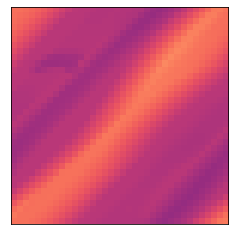

In [7]:
pols281 = []
for i in range(20):
  pol281 = check_ens_xy(actors[i], (-.5,0.))
  pol281 = pol281[1].detach().numpy()
  plt.imshow(pol281[:,1].reshape(36,36),vmin=.45,vmax=.55,cmap='magma')
  plt.xticks([])
  plt.yticks([]);

  pols281.append(pol281[:,1])

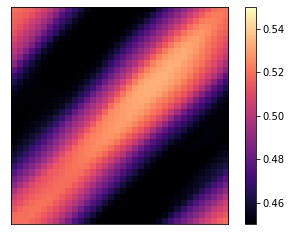

In [8]:
pols_array281 = np.mean(np.vstack(pols281), axis=0).reshape(36,36)
plt.imshow(pols_array281,vmin=.45,vmax=.55,cmap='magma')
plt.xticks([])
plt.yticks([])
plt.colorbar();

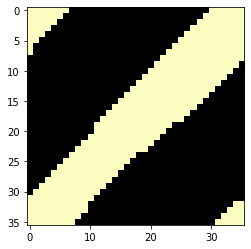

In [9]:
standard = np.sign(pols_array281-.5)
standardNT = pols_array281
plt.imshow(standard, cmap='magma')

In [13]:
score = np.zeros((22,20))
bigscore = np.zeros(22)

actors = load_ens(l281,f'init')
pols281 = []

for i in range(20):
  pol281 = check_ens_xy(actors[i], (-.5,0.))
  pol281 = pol281[1].detach().numpy()
  pol281 = pol281[:,1].reshape(36,36)

  pols281.append(pol281.flatten())

  score[0,i] = np.linalg.norm(standard - np.sign(pol281-.5))

pols_array281 = np.mean(np.vstack(pols281), axis=0).reshape(36,36)
bigscore[0] = np.linalg.norm(standard - np.sign(pols_array281-.5))


for epoch in np.arange(20)+1:
  actors = load_ens(l281,f'e{epoch-1}')
  pols281 = []

  for i in range(20):
    pol281 = check_ens_xy(actors[i], (-.5,0.))
    pol281 = pol281[1].detach().numpy()
    pol281 = pol281[:,1].reshape(36,36)

    pols281.append(pol281.flatten())

    score[epoch,i] = np.linalg.norm(standard - np.sign(pol281-.5))
  
  pols_array281 = np.mean(np.vstack(pols281), axis=0).reshape(36,36)
  bigscore[epoch] = np.linalg.norm(standard - np.sign(pols_array281-.5))

actors = load_ens(l281,f'fin')
pols281 = []

for i in range(20):
  pol281 = check_ens_xy(actors[i], (-.5,0.))
  pol281 = pol281[1].detach().numpy()
  pol281 = pol281[:,1].reshape(36,36)

  pols281.append(pol281.flatten())

  score[-1,i] = np.linalg.norm(standard - np.sign(pol281-.5))

pols_array281 = np.mean(np.vstack(pols281), axis=0).reshape(36,36)
bigscore[-1] = np.linalg.norm(standard - np.sign(pols_array281-.5))

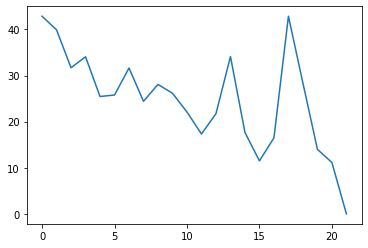

In [14]:
plt.plot(bigscore)
plt.savefig('Figs/281EnsembleTrainingScores.svg')

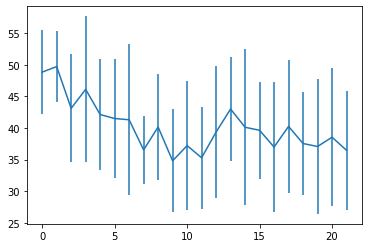

In [16]:
plt.errorbar(np.arange(22), np.mean(score,axis=1), yerr=np.std(score,axis=1))
#plt.axis([0,20,0,60])
plt.savefig('Figs/281AgentTrainingScores.svg')

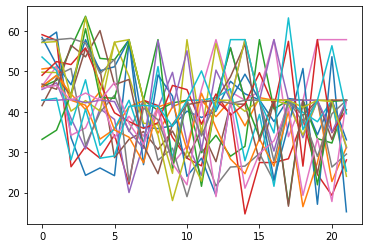

In [17]:
for i in range(20):
  plt.plot(score[:,i])
#plt.axis([0,20,0,70])
plt.savefig('Figs/281IndividualAgentTrainingScores.svg')

In [18]:
# non thresholded
score = np.zeros((22,20))
bigscore = np.zeros(22)

actors = load_ens(l281,f'init')
pols281 = []

for i in range(20):
  pol281 = check_ens_xy(actors[i], (-.5,0.))
  pol281 = pol281[1].detach().numpy()
  pol281 = pol281[:,1].reshape(36,36)

  pols281.append(pol281.flatten())

  score[0,i] = np.linalg.norm(standardNT - pol281)

pols_array281 = np.mean(np.vstack(pols281), axis=0).reshape(36,36)
bigscore[0] = np.linalg.norm(standardNT - pols_array281)


for epoch in np.arange(20)+1:
  actors = load_ens(l281,f'e{epoch-1}')
  pols281 = []

  for i in range(20):
    pol281 = check_ens_xy(actors[i], (-.5,0.))
    pol281 = pol281[1].detach().numpy()
    pol281 = pol281[:,1].reshape(36,36)

    pols281.append(pol281.flatten())

    score[epoch,i] = np.linalg.norm(standardNT - pol281)
  
  pols_array281 = np.mean(np.vstack(pols281), axis=0).reshape(36,36)
  bigscore[epoch] = np.linalg.norm(standardNT - pols_array281)

actors = load_ens(l281,f'fin')
pols281 = []

for i in range(20):
  pol281 = check_ens_xy(actors[i], (-.5,0.))
  pol281 = pol281[1].detach().numpy()
  pol281 = pol281[:,1].reshape(36,36)

  pols281.append(pol281.flatten())

  score[-1,i] = np.linalg.norm(standardNT - pol281)

pols_array281 = np.mean(np.vstack(pols281), axis=0).reshape(36,36)
bigscore[-1] = np.linalg.norm(standardNT - pols_array281)

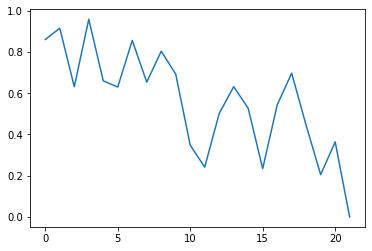

In [19]:
plt.plot(bigscore)
plt.savefig('Figs/281EnsembleTrainingScoresNT.svg')

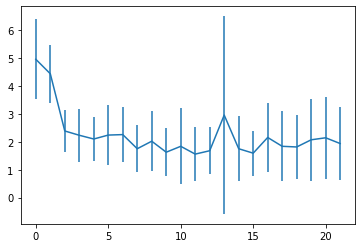

In [20]:
plt.errorbar(np.arange(22), np.mean(score,axis=1), yerr=np.std(score,axis=1))
#plt.axis([0,20,0,60])
plt.savefig('Figs/281AgentTrainingScoresNT.svg')

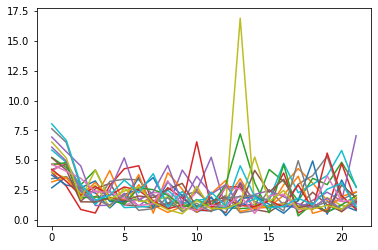

In [21]:
for i in range(20):
  plt.plot(score[:,i])
#plt.axis([0,20,0,70])
plt.savefig('Figs/281IndividualAgentTrainingScoresNT.svg')

# 301

In [22]:
actors = load_ens(l301,'fin')

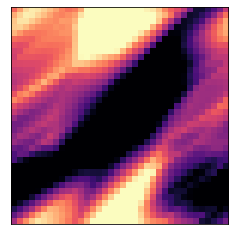

In [23]:
pols301 = []
for i in range(20):
  pol301 = check_ens_xy(actors[i], (-.5,0.))
  pol301 = pol301[1].detach().numpy()
  plt.imshow(pol301[:,1].reshape(36,36),vmin=.45,vmax=.55,cmap='magma')
  plt.xticks([])
  plt.yticks([]);

  pols301.append(pol301[:,1])

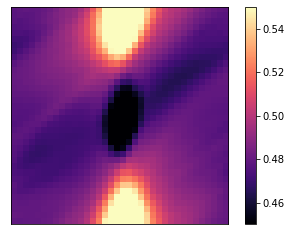

In [24]:
pols_array301 = np.mean(np.vstack(pols301), axis=0).reshape(36,36)
plt.imshow(pols_array301,vmin=.45,vmax=.55,cmap='magma')
plt.xticks([])
plt.yticks([])
plt.colorbar();

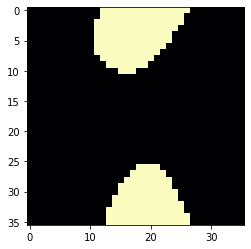

In [25]:
standard = np.sign(pols_array301-.5)
standardNT = pols_array301
plt.imshow(standard, cmap='magma')

In [30]:
score = np.zeros((22,20))
bigscore = np.zeros(22)

actors = load_ens(l301,f'init')
pols301 = []

for i in range(20):
  pol301 = check_ens_xy(actors[i], (-.5,0.))
  pol301 = pol301[1].detach().numpy()
  pol301 = pol301[:,1].reshape(36,36)

  pols301.append(pol301.flatten())

  score[0,i] = np.linalg.norm(standard - np.sign(pol301-.5))

pols_array301 = np.mean(np.vstack(pols301), axis=0).reshape(36,36)
bigscore[0] = np.linalg.norm(standard - np.sign(pols_array301-.5))


for epoch in np.arange(20)+1:
  actors = load_ens(l301,f'e{epoch-1}')
  pols301 = []

  for i in range(20):
    pol301 = check_ens_xy(actors[i], (-.5,0.))
    pol301 = pol301[1].detach().numpy()
    pol301 = pol301[:,1].reshape(36,36)

    pols301.append(pol301.flatten())

    score[epoch,i] = np.linalg.norm(standard - np.sign(pol301-.5))
  
  pols_array301 = np.mean(np.vstack(pols301), axis=0).reshape(36,36)
  bigscore[epoch] = np.linalg.norm(standard - np.sign(pols_array301-.5))

actors = load_ens(l301,f'fin')
pols301 = []

for i in range(20):
  pol301 = check_ens_xy(actors[i], (-.5,0.))
  pol301 = pol301[1].detach().numpy()
  pol301 = pol301[:,1].reshape(36,36)

  pols301.append(pol301.flatten())

  score[-1,i] = np.linalg.norm(standard - np.sign(pol301-.5))

pols_array301 = np.mean(np.vstack(pols301), axis=0).reshape(36,36)
bigscore[-1] = np.linalg.norm(standard - np.sign(pols_array301-.5))

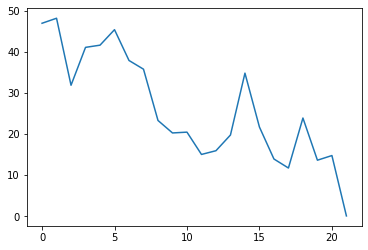

In [31]:
plt.plot(bigscore)
plt.savefig('Figs/301EnsembleTrainingScores.svg')

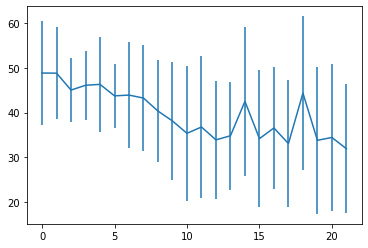

In [32]:
plt.errorbar(np.arange(22), np.mean(score,axis=1), yerr=np.std(score,axis=1))
#plt.axis([0,20,0,60])
plt.savefig('Figs/301AgentTrainingScores.svg')

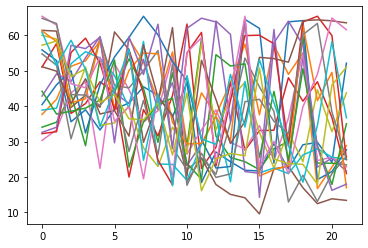

In [33]:
for i in range(20):
  plt.plot(score[:,i])
#plt.axis([0,20,0,70])
plt.savefig('Figs/301IndividualAgentTrainingScores.svg')

In [34]:
# non thresholded
score = np.zeros((22,20))
bigscore = np.zeros(22)

actors = load_ens(l301,f'init')
pols301 = []

for i in range(20):
  pol301 = check_ens_xy(actors[i], (-.5,0.))
  pol301 = pol301[1].detach().numpy()
  pol301 = pol301[:,1].reshape(36,36)

  pols301.append(pol301.flatten())

  score[0,i] = np.linalg.norm(standardNT - pol301)

pols_array301 = np.mean(np.vstack(pols301), axis=0).reshape(36,36)
bigscore[0] = np.linalg.norm(standardNT - pols_array301)


for epoch in np.arange(20)+1:
  actors = load_ens(l301,f'e{epoch-1}')
  pols301 = []

  for i in range(20):
    pol301 = check_ens_xy(actors[i], (-.5,0.))
    pol301 = pol301[1].detach().numpy()
    pol301 = pol301[:,1].reshape(36,36)

    pols301.append(pol301.flatten())

    score[epoch,i] = np.linalg.norm(standardNT - pol301)
  
  pols_array301 = np.mean(np.vstack(pols301), axis=0).reshape(36,36)
  bigscore[epoch] = np.linalg.norm(standardNT - pols_array301)

actors = load_ens(l301,f'fin')
pols301 = []

for i in range(20):
  pol301 = check_ens_xy(actors[i], (-.5,0.))
  pol301 = pol301[1].detach().numpy()
  pol301 = pol301[:,1].reshape(36,36)

  pols301.append(pol301.flatten())

  score[-1,i] = np.linalg.norm(standardNT - pol301)

pols_array301 = np.mean(np.vstack(pols301), axis=0).reshape(36,36)
bigscore[-1] = np.linalg.norm(standardNT - pols_array301)

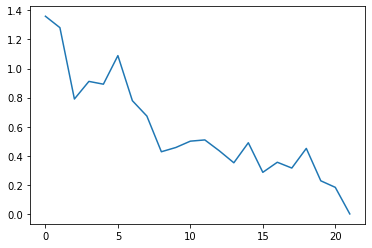

In [35]:
plt.plot(bigscore)
plt.savefig('Figs/301EnsembleTrainingScoresNT.svg')

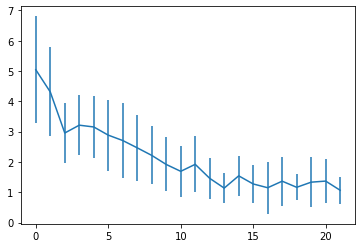

In [36]:
plt.errorbar(np.arange(22), np.mean(score,axis=1), yerr=np.std(score,axis=1))
#plt.axis([0,20,0,60])
plt.savefig('Figs/301AgentTrainingScoresNT.svg')

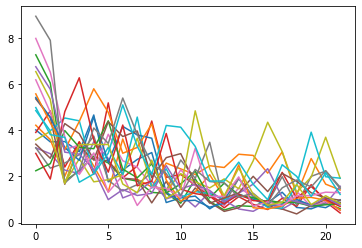

In [37]:
for i in range(20):
  plt.plot(score[:,i])
#plt.axis([0,20,0,70])
plt.savefig('Figs/301IndividualAgentTrainingScoresNT.svg')

# 352

In [38]:
actors = load_ens(l352,'fin')

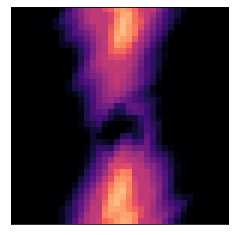

In [39]:
pols352 = []
for i in range(20):
  pol352 = check_ens_xy(actors[i], (-.5,0.))
  pol352 = pol352[1].detach().numpy()
  plt.imshow(pol352[:,1].reshape(36,36),vmin=.45,vmax=.55,cmap='magma')
  plt.xticks([])
  plt.yticks([]);

  pols352.append(pol352[:,1])

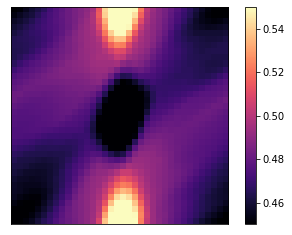

In [40]:
pols_array352 = np.mean(np.vstack(pols352), axis=0).reshape(36,36)
plt.imshow(pols_array352,vmin=.45,vmax=.55,cmap='magma')
plt.xticks([])
plt.yticks([])
plt.colorbar();

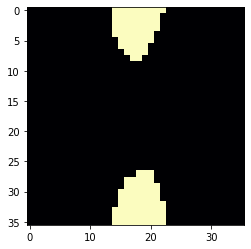

In [41]:
standard = np.sign(pols_array352-.5)
standardNT = pols_array352
plt.imshow(standard, cmap='magma')

In [45]:
score = np.zeros((22,20))
bigscore = np.zeros(22)

actors = load_ens(l352,f'init')
pols352 = []

for i in range(20):
  pol352 = check_ens_xy(actors[i], (-.5,0.))
  pol352 = pol352[1].detach().numpy()
  pol352 = pol352[:,1].reshape(36,36)

  pols352.append(pol352.flatten())

  score[0,i] = np.linalg.norm(standard - np.sign(pol352-.5))

pols_array352 = np.mean(np.vstack(pols352), axis=0).reshape(36,36)
bigscore[0] = np.linalg.norm(standard - np.sign(pols_array352-.5))


for epoch in np.arange(20)+1:
  actors = load_ens(l352,f'e{epoch-1}')
  pols352 = []

  for i in range(20):
    pol352 = check_ens_xy(actors[i], (-.5,0.))
    pol352 = pol352[1].detach().numpy()
    pol352 = pol352[:,1].reshape(36,36)

    pols352.append(pol352.flatten())

    score[epoch,i] = np.linalg.norm(standard - np.sign(pol352-.5))
  
  pols_array352 = np.mean(np.vstack(pols352), axis=0).reshape(36,36)
  bigscore[epoch] = np.linalg.norm(standard - np.sign(pols_array352-.5))

actors = load_ens(l352,f'fin')
pols352 = []

for i in range(20):
  pol352 = check_ens_xy(actors[i], (-.5,0.))
  pol352 = pol352[1].detach().numpy()
  pol352 = pol352[:,1].reshape(36,36)

  pols352.append(pol352.flatten())

  score[-1,i] = np.linalg.norm(standard - np.sign(pol352-.5))

pols_array352 = np.mean(np.vstack(pols352), axis=0).reshape(36,36)
bigscore[-1] = np.linalg.norm(standard - np.sign(pols_array352-.5))

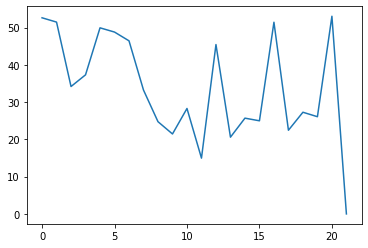

In [46]:
plt.plot(bigscore)
plt.savefig('Figs/352EnsembleTrainingScores.svg')

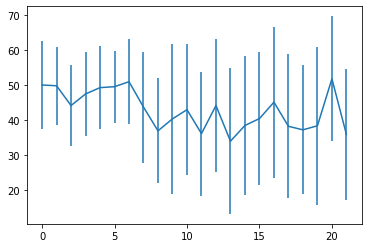

In [47]:
plt.errorbar(np.arange(22), np.mean(score,axis=1), yerr=np.std(score,axis=1))
#plt.axis([0,20,0,60])
plt.savefig('Figs/352AgentTrainingScores.svg')

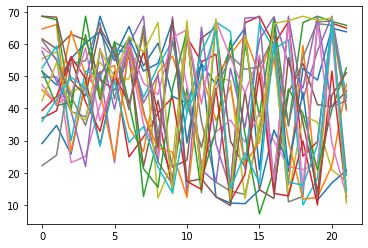

In [48]:
for i in range(20):
  plt.plot(score[:,i])
#plt.axis([0,20,0,70])
plt.savefig('Figs/352IndividualAgentTrainingScores.svg')

In [49]:
# non thresholded
score = np.zeros((22,20))
bigscore = np.zeros(22)

actors = load_ens(l352,f'init')
pols352 = []

for i in range(20):
  pol352 = check_ens_xy(actors[i], (-.5,0.))
  pol352 = pol352[1].detach().numpy()
  pol352 = pol352[:,1].reshape(36,36)

  pols352.append(pol352.flatten())

  score[0,i] = np.linalg.norm(standardNT - pol352)

pols_array352 = np.mean(np.vstack(pols352), axis=0).reshape(36,36)
bigscore[0] = np.linalg.norm(standardNT - pols_array352)


for epoch in np.arange(20)+1:
  actors = load_ens(l352,f'e{epoch-1}')
  pols352 = []

  for i in range(20):
    pol352 = check_ens_xy(actors[i], (-.5,0.))
    pol352 = pol352[1].detach().numpy()
    pol352 = pol352[:,1].reshape(36,36)

    pols352.append(pol352.flatten())

    score[epoch,i] = np.linalg.norm(standardNT - pol352)
  
  pols_array352 = np.mean(np.vstack(pols352), axis=0).reshape(36,36)
  bigscore[epoch] = np.linalg.norm(standardNT - pols_array352)

actors = load_ens(l352,f'fin')
pols352 = []

for i in range(20):
  pol352 = check_ens_xy(actors[i], (-.5,0.))
  pol352 = pol352[1].detach().numpy()
  pol352 = pol352[:,1].reshape(36,36)

  pols352.append(pol352.flatten())

  score[-1,i] = np.linalg.norm(standardNT - pol352)

pols_array352 = np.mean(np.vstack(pols352), axis=0).reshape(36,36)
bigscore[-1] = np.linalg.norm(standardNT - pols_array352)

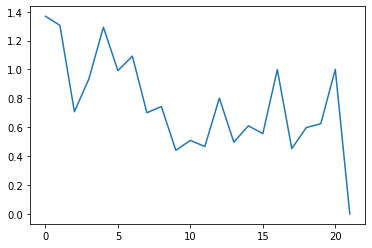

In [50]:
plt.plot(bigscore)
plt.savefig('Figs/352EnsembleTrainingScoresNT.svg')

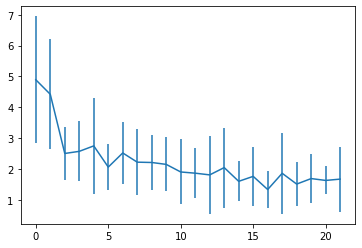

In [52]:
plt.errorbar(np.arange(22), np.mean(score,axis=1), yerr=np.std(score,axis=1))
#plt.axis([0,20,0,60])
plt.savefig('Figs/352AgentTrainingScoresNT.svg')

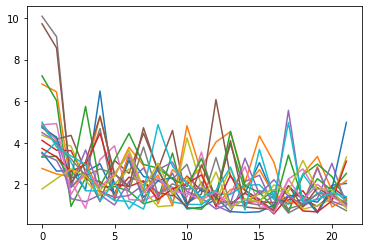

In [53]:
for i in range(20):
  plt.plot(score[:,i])
#plt.axis([0,20,0,70])
plt.savefig('Figs/352IndividualAgentTrainingScoresNT.svg')